#####Configuración Inicial

In [1]:
#Configuración inicial ─────────────────────────────────────────
from google.colab import drive
# Imports y rutas ───────────────────────────────────────────────────
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v2 as iio
import cv2
from skimage.exposure import equalize_adapthist
from skimage.filters import gaussian
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
from tifffile import imwrite, imread
from tqdm import tqdm

# Rutas relativas (no creamos aún las carpetas de salida)
BASE_DIR = Path('/content/drive/MyDrive/Nanolive') # Definir raíz del repositorio
STACK_DIR     = BASE_DIR / 'stack_imagenes'        #Carpeta con los stacks de TIFF
PREDECONV_DIR = BASE_DIR / 'pre_deconvolucion'     # Salida general
SUBVOLUME_DIR = PREDECONV_DIR / 'subvolumenes'     #Subvolúmenes alineados
PSF_DIR       = PREDECONV_DIR / 'psfs'             #PSFs (promedio y suavizadas)
DECONV_RESULTS_DIR = BASE_DIR / 'deconvolucion_resultados'#Resultados deconvolución Fiji
LOG_CSV_PATH       = DECONV_RESULTS_DIR / 'log_deconvoluciones.csv'#Organización de las deconvoluciones

# Montar Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Carga de Stacks

In [2]:

# Directorio base con stack_1, stack_2, …
dirs_stacks = sorted([d for d in STACK_DIR.iterdir() if d.is_dir() and d.name.startswith('stack_')])

stacks = {}
for d in dirs_stacks:
    tiff_files = sorted(d.glob('*.tif'))
    if not tiff_files:
        print(f"⚠️ {d.name} está vacío o no tiene .tif")
        continue

    stack = np.stack([
        iio.imread(str(f))
        for f in tqdm(tiff_files, desc=f"Cargando {d.name}")
    ])
    stacks[d.name] = stack


Cargando stack_4: 100%|██████████| 96/96 [00:04<00:00, 22.27it/s]


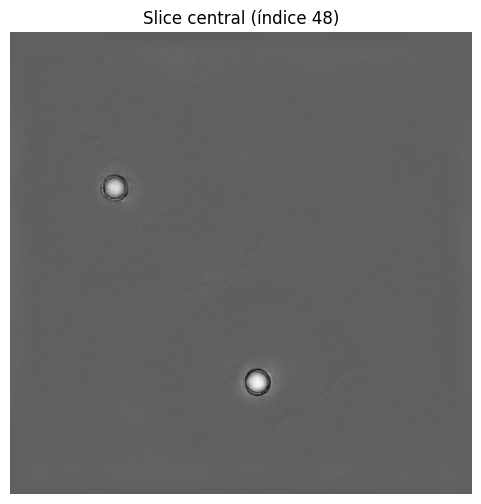

In [3]:
# Visualización slice central
slice_central = stack.shape[0] // 2

plt.figure(figsize=(6,6))
plt.imshow(stack[slice_central], cmap='gray')
plt.title(f"Slice central (índice {slice_central})")
plt.axis('off')
plt.show()


###### Detección de microesferas en diferentes planos

###### Explicación detección de microesferas
  Máxima Proyección en Z (MIP): Partimos de un volumen 3D (Z, Y, X) y colapsamos la dimensión Z reteniendo el valor máximo de intensidad en cada posición XY.

  Esto nos da una imagen 2D donde las microesferas (que aparecen como “puntos brillantes” en distintos planos) se realzan, facilitando su detección en un solo paso.

  Ecualización y Suavizado: La ecualización adaptativa (equalize_adapthist) redistribuye el contraste local, de modo que zonas oscuras y brillantes queden equilibradas; esto ayuda a que los “blobs” de diferentes intensidades sean igualmente detectables.

  La aplicación de un filtro Gaussiano reduce el ruido fino (píxeles aislados o textura indeseada), enfocándonos en estructuras del tamaño aproximado de la microesfera.

  Recorte de Bordes: Descartamos automáticamente un margen fijo (25 px) alrededor de la imagen para evitar detecciones espurias debidas a artefactos de recorte o bordes mal calibrados.

  Detección de “Blobs” con LoG: Usamos el filtro Laplaciano de Gaussiano (blob_log) calibrado al radio esperado (≈11 px) para identificar regiones circulares brillantes.

  Esto nos devuelve un conjunto de coordenadas XY aproximadas de cada microesfera proyectada.

  Filtrado Estricto de Proximidad: Para asegurar que las PSFs de esferas muy cercanas no se solapen, descartamos todas las detecciones que tengan un vecino a menos de 2 diámetros (46 px).

  Así nos quedamos solo con aquellas esferas que podemos tratar de forma independiente en fases posteriores.

  Localización de Z de Pico de Intensidad: Para cada posición XY valida, recorremos el canal Z en esa coordenada y seleccionamos el slice donde la intensidad es máxima; es decir, el plano focal de cada microesfera.

  Refinamiento con Contornos: En una ventana local de 31×31 px centrada en el punto detectado, convertimos la subimagen a 8-bit y aplicamos Otsu para segmentar el contorno real de la esfera.

  Calculamos el centroide del contorno más grande para ajustar la coordenada XY con precisión sub-pixel, mejorando la exactitud de la localización.

  Visualización y Salida: Mostramos en una única figura la MIP con todos los centros refinados, permitiendo una validación rápida de la detección.

  Finalmente, almacenamos únicamente estas coordenadas refinadas en results, de modo que la siguiente celda puede usar directamente results[name] para recortar cada subvolumen original y proceder al cálculo de la PSF sin ambigüedades ni redundancias.


🔄 Procesando stack_1 (shape (96, 512, 512))


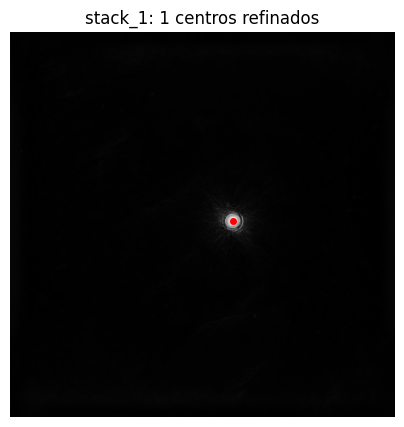


🔄 Procesando stack_2 (shape (96, 512, 512))


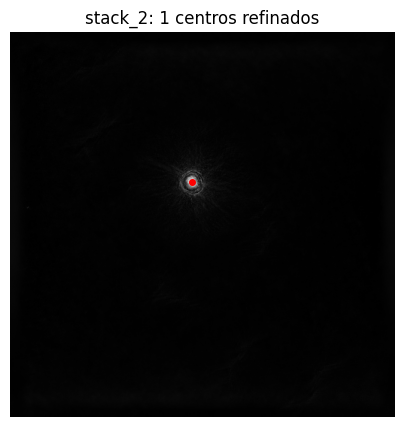


🔄 Procesando stack_3 (shape (96, 512, 512))


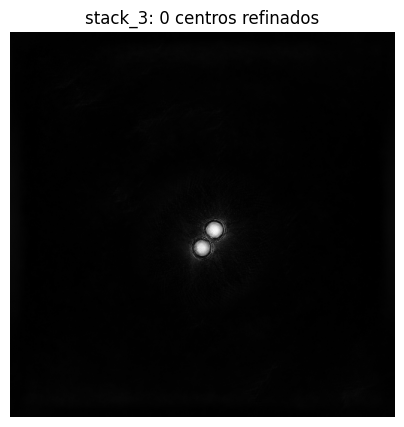


🔄 Procesando stack_4 (shape (96, 512, 512))


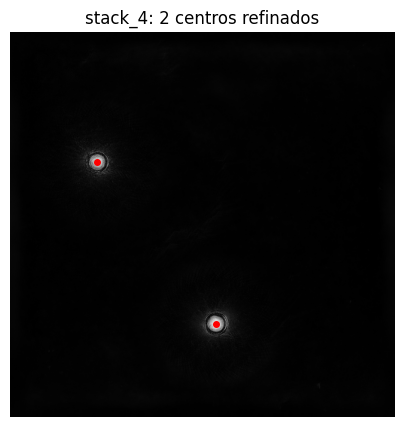

In [4]:

# Diccionario final: centros refinados
results = {}

for name, stack in stacks.items():
    print(f"\n🔄 Procesando {name} (shape {stack.shape})")

    # 1) Máxima proyección en Z (MIP)
    mip = stack.max(axis=0)

    # 2) Normalizar y ecualizar contraste adaptativo
    mip_norm = (mip - mip.min()) / (mip.max() - mip.min())
    mip_eq   = equalize_adapthist(mip_norm)

    # 3) Suavizado gaussiano para reducir ruido fino
    mip_blur = gaussian(mip_eq, sigma=1)

    # 4) Eliminar bordes para evitar falsas detecciones
    margin = 25
    mip_blur[:margin, :] = 0
    mip_blur[-margin:, :] = 0
    mip_blur[:, :margin] = 0
    mip_blur[:, -margin:] = 0

    # 5) Detección de “blobs” → centros XY aproximados
    blobs      = blob_log(
        mip_blur,
        min_sigma=8.8,      # radio ≈ 11 px ±20%
        max_sigma=13.2,
        num_sigma=5,
        threshold=0.03
    )
    centers_xy = [(int(y), int(x)) for y, x, _ in blobs]

    # 6) Filtrado estricto: descartar centros con vecinos < 2 diámetros (46 px)
    min_dist   = 2 * 23
    filtered_xy = []
    for y, x in centers_xy:
        # cuenta otros centros en un radio de min_dist
        close = sum(
            1 for yy, xx in centers_xy
            if (y - yy)**2 + (x - xx)**2 < min_dist**2 and (yy, xx) != (y, x)
        )
        if close == 0:
            filtered_xy.append((y, x))
    centers_xy = filtered_xy

    # 7) Para cada centro XY, encontrar la Z de máxima intensidad
    Z, Y, X = stack.shape
    centers_3d = [(int(np.argmax(stack[:, y, x])), y, x) for y, x in centers_xy]

    # 8) Refinamiento con contornos en una ventana de 31×31 píxeles
    ventana = 31
    offset  = ventana // 2
    refined = []
    for z, y, x in centers_3d:
        # si está muy cerca del borde, no refinamos
        if not (offset <= y < Y-offset and offset <= x < X-offset):
            refined.append((z, y, x))
            continue

        # extraer parche 2D en el plano Z
        patch = stack[z, y-offset:y+offset+1, x-offset:x+offset+1]

        # normalizar directamente a 0–255 y pasar a uint8
        patch_u8 = cv2.normalize(patch, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # umbral con Otsu y búsqueda de contornos
        _, mask = cv2.threshold(patch_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if cnts:
            # escoger el contorno más grande y calcular su centroide
            c = max(cnts, key=cv2.contourArea)
            M = cv2.moments(c)
            if M['m00'] != 0:
                cx = x - offset + (M['m10'] / M['m00'])
                cy = y - offset + (M['m01'] / M['m00'])
                refined.append((z, cy, cx))
                continue

        # si no refinó, añadimos la coordenada original
        refined.append((z, y, x))

    # 9) Visualización de todos los centros refinados sobre la MIP
    plt.figure(figsize=(5,5))
    plt.imshow(mip, cmap='gray')
    for z, y, x in refined:
        plt.plot(x, y, 'ro', markersize=4)
    plt.title(f"{name}: {len(refined)} centros refinados")
    plt.axis('off')
    plt.show()

    # 10) Guardamos solo los centros refinados
    results[name] = refined


##### Extracción y visualización de subvolumenes alineados

In [5]:
# Función de visualización
def visualizar_subvolumenes(subvols):
    """
    Visualiza cortes XY, XZ y YZ del plano central de cada subvolumen.
    """
    for i, vol in enumerate(subvols):
        z_c = vol.shape[0] // 2
        y_c = vol.shape[1] // 2
        x_c = vol.shape[2] // 2

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(vol[z_c], cmap='gray')
        axs[0].set_title(f'#{i+1} - Plano XY (Z={z_c})')
        axs[1].imshow(vol[:, y_c, :], cmap='gray')
        axs[1].set_title(f'#{i+1} - Plano XZ (Y={y_c})')
        axs[2].imshow(vol[:, :, x_c], cmap='gray')
        axs[2].set_title(f'#{i+1} - Plano YZ (X={x_c})')

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

La siguiente celda se encarga de extraer y homogeneizar todos los subvolúmenes centrados en las microesferas para luego calcular una PSF global alineada:

- Recolectar márgenes:
Para cada centro refinado de cada stack, anota cuántos slices hay encima y debajo dentro del volumen original.

- Calcular margen simétrico:
Elige el valor mínimo entre todos esos márgenes arriba y abajo, de modo que desde cada centro puedas subir y bajar exactamente la misma cantidad de slices.

- Extraer subvolúmenes uniformes:
Con ese margen común y un tamaño fijo en Y–X, recorta alrededor de cada centro una ventana 3D idéntica para todas las microesferas.

- Verificar uniformidad:
Comprueba que cada recorte tenga la misma forma (profundidad y ancho), descartando cualquier subvolumen mal formado.

Margen simétrico en Z: 39 slices arriba y abajo → profundidad total 79
🔎 Visualizando subvolúmenes alineados por stack:

stack_1 (1 subvolúmenes):


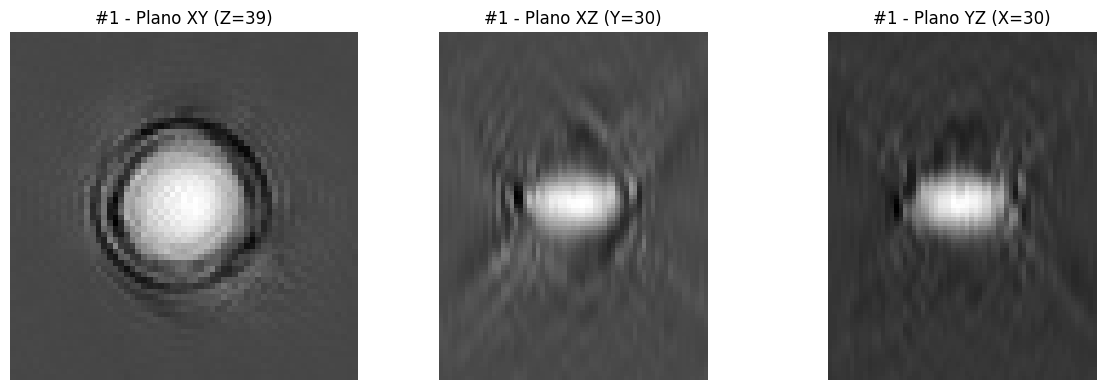


stack_2 (1 subvolúmenes):


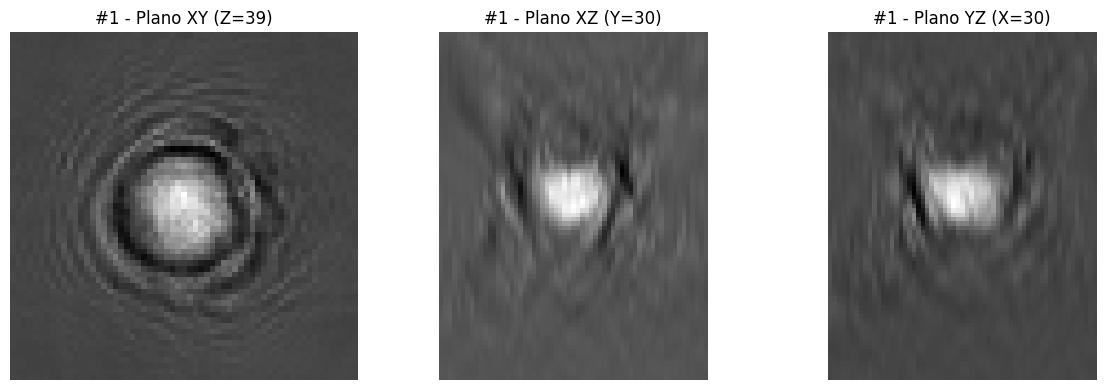


stack_3 (0 subvolúmenes):

stack_4 (2 subvolúmenes):


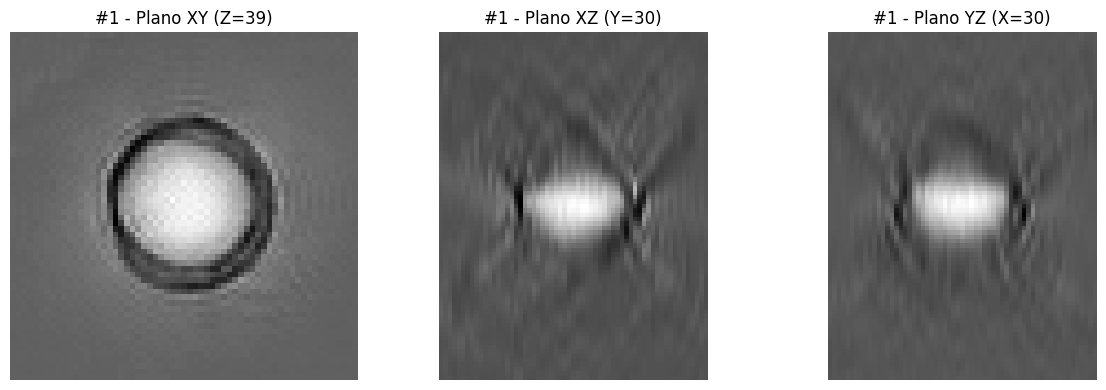

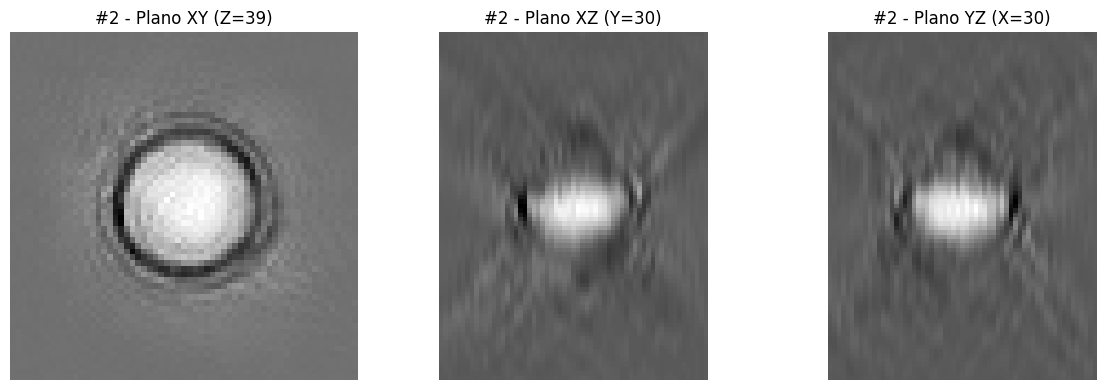

Formas de subvolúmenes reextraídos (debería ser única): {(79, 61, 61)}


In [6]:

#Determinar márgenes globales arriba/abajo para todos los centros
global_up   = []
global_down = []
for name, refined in results.items():
    Z = stacks[name].shape[0]
    for z, y, x in refined:
        global_up.append(int(z))
        global_down.append(Z - int(z) - 1)

#Calcular margen simétrico (mínimo de ambos)
margin_sym = min(min(global_up), min(global_down))
depth      = 2 * margin_sym + 1
print(f"Margen simétrico en Z: {margin_sym} slices arriba y abajo → profundidad total {depth}")

# Volver a extraer todos los subvolúmenes en un dict
ventana = 61
offset  = ventana // 2
uniform_subvols = {}  # ahora dict: { stack_name: [subvols...] }

for name, refined in results.items():
    stack = stacks[name]
    subvols = []
    for z, y, x in refined:
        # límites Z perfectamente simétricos
        z0, z1 = z - margin_sym, z + margin_sym + 1
        # límites XY
        y0, y1 = int(round(y)) - offset, int(round(y)) + offset + 1
        x0, x1 = int(round(x)) - offset, int(round(x)) + offset + 1

        subvol = stack[z0:z1, y0:y1, x0:x1]
        subvols.append(subvol)
    uniform_subvols[name] = subvols

#Visualizar subvolúmenes por stack
print("🔎 Visualizando subvolúmenes alineados por stack:")
for name, subs in uniform_subvols.items():
    print(f"\n{name} ({len(subs)} subvolúmenes):")
    if subs:
        visualizar_subvolumenes(subs)

#Verificar que todos los subvolúmenes tienen la misma forma
all_shapes = {sv.shape for subs in uniform_subvols.values() for sv in subs}
print("Formas de subvolúmenes reextraídos (debería ser única):", all_shapes)


##### Cálculo y visualización de PSF global para varios sigmas

PSF global calculada con alineamiento simétrico: (79, 61, 61)

🔍 PSF global σ=0


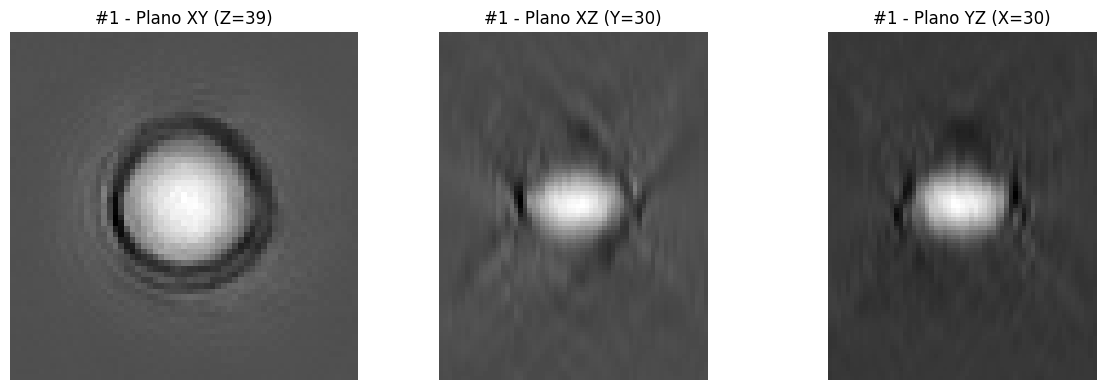


🔍 PSF global σ=0.5


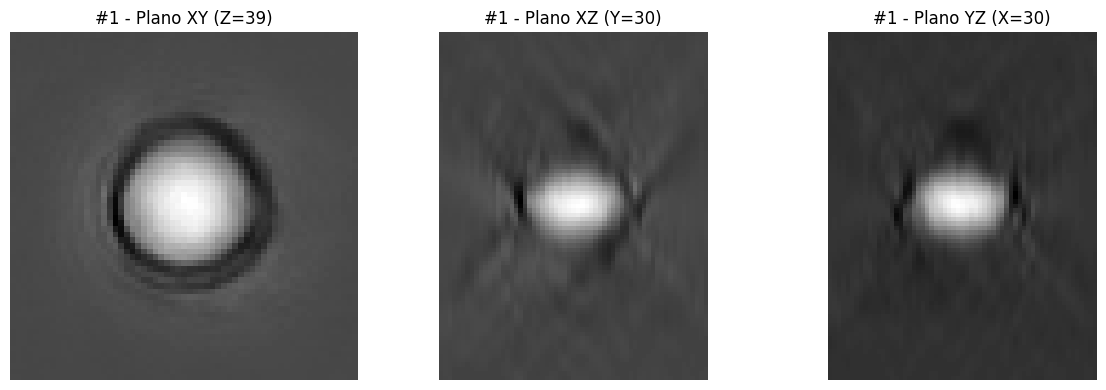


🔍 PSF global σ=1.0


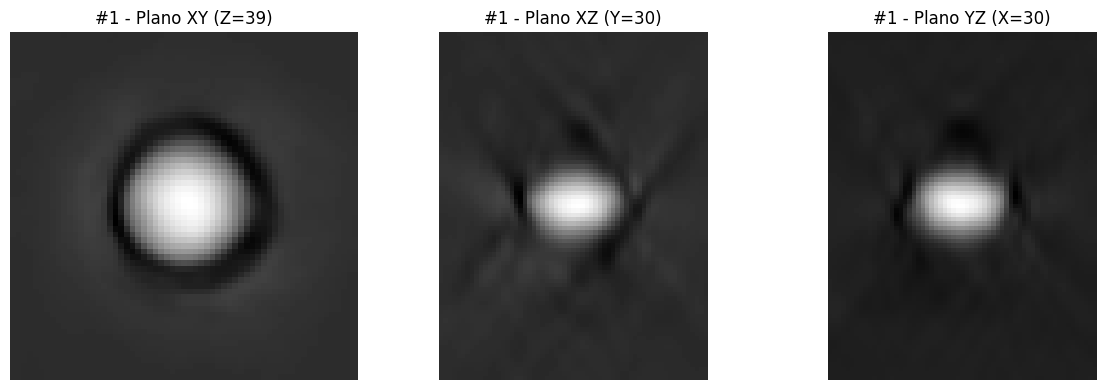


🔍 PSF global σ=1.5


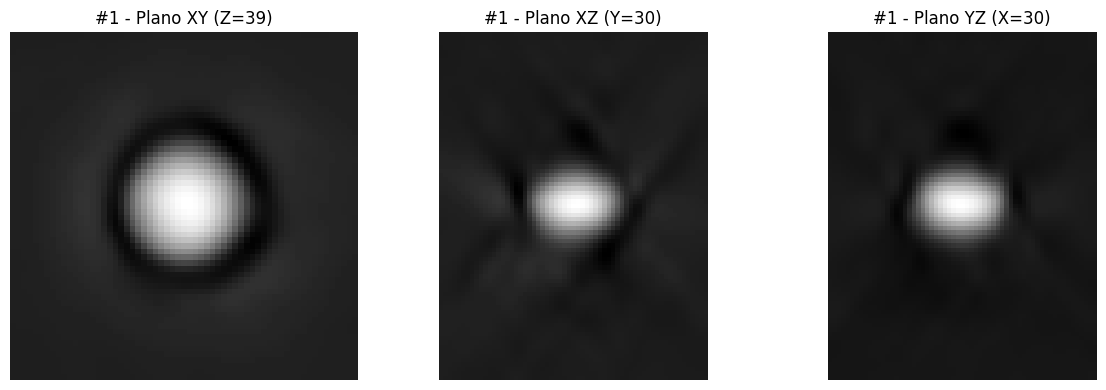


🔍 PSF global σ=2.0


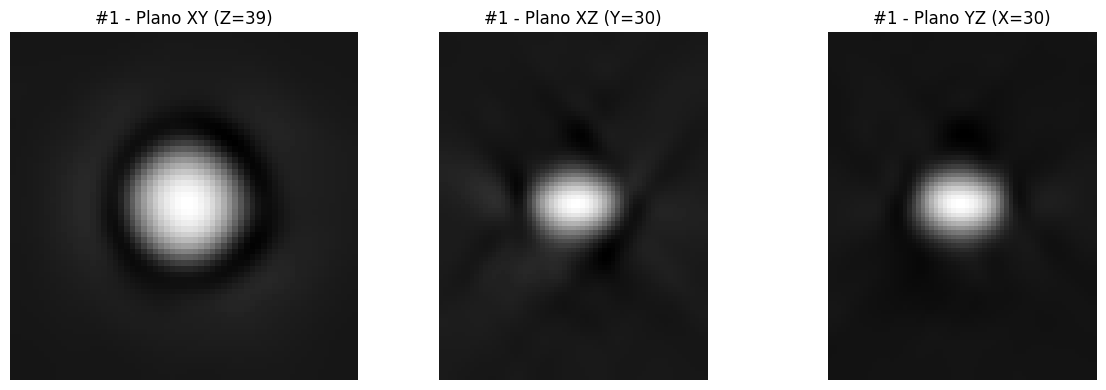

In [7]:
#subvolúmenes del dict uniform_subvols
all_subvols = [vol
               for sublist in uniform_subvols.values()
               for vol in sublist]

if not all_subvols:
    print("⚠️ No hay subvolúmenes para calcular la PSF global.")
else:
    #Apilar y promediar para obtener la PSF global
    arr = np.stack(all_subvols, axis=0)   # (N_total, depth, ventana, ventana)
    psf_global_sym = arr.mean(axis=0)     # (depth, ventana, ventana)
    print("PSF global calculada con alineamiento simétrico:", psf_global_sym.shape)

    #Suavizado con varios sigmas y visualización
    sigmas = [0, 0.5, 1.0, 1.5, 2.0]
    psf_smooth_dict = {}

    for sigma in sigmas:
        psf_sm = gaussian_filter(psf_global_sym, sigma=sigma)
        psf_smooth_dict[sigma] = psf_sm

        print(f"\n🔍 PSF global σ={sigma}")
        visualizar_subvolumenes([psf_sm])

    # psf_smooth_dict ahora contiene las PSFs suavizadas para cada sigma


##### Cálculo y visualización comparativa: Volumen a 50 % y SNR vs σ 

In [ ]:
# Cálculo de Volumen 50 % y SNR para cada σ de PSF suavizada

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lista para almacenar resultados
metrics = []

# Recorremos cada PSF suavizada
for sigma, psf_sm in psf_smooth_dict.items():
    # Normalizar la PSF al rango [0,1]
    psf_min, psf_max = psf_sm.min(), psf_sm.max()
    psf_norm = (psf_sm - psf_min) / (psf_max - psf_min)
    
    # Volumen al 50% (número y %)
    th = 0.5
    mask = psf_norm >= th
    n_vox = int(mask.sum())
    pct = n_vox / psf_norm.size * 100
    
    # Señal y Ruido (mismo fondo de 3 capas perimetrales)
    signal = psf_norm.max()
    bkg = np.concatenate([
        psf_norm[:3].ravel(), psf_norm[-3:].ravel(),
        psf_norm[:, :3, :].ravel(), psf_norm[:, -3:, :].ravel(),
        psf_norm[:, :, :3].ravel(), psf_norm[:, :, -3:].ravel()
    ])
    noise = bkg.std()
    snr = signal / noise if noise > 0 else np.nan
    
    metrics.append({  
        'sigma': sigma,
        'vol_vox': n_vox,
        'vol_pct': pct,
        'snr': snr
    })

# Convertir a DataFrame
df_metrics = pd.DataFrame(metrics).sort_values('sigma')
df_metrics


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Volumen efectivo (% del total) vs σ
axes[0].plot(df_metrics['sigma'], df_metrics['vol_pct'], marker='o', linestyle='-')
axes[0].set_title("Volumen ≥50 % vs σ")
axes[0].set_xlabel("σ del suavizado")
axes[0].set_ylabel("Volumen ≥50 % (%)")
axes[0].set_xticks(df_metrics['sigma'])
axes[0].grid(True)

# SNR vs σ
axes[1].plot(df_metrics['sigma'], df_metrics['snr'], marker='o', linestyle='-')
axes[1].set_title("SNR vs σ")
axes[1].set_xlabel("σ del suavizado")
axes[1].set_ylabel("SNR (pico / σ_fondo)")
axes[1].set_xticks(df_metrics['sigma'])
axes[1].grid(True)

plt.tight_layout()
plt.show()


##### Guardado de subvolumenes y PSFs en carpetas separadas.

In [8]:
#Crear las carpetas de salida si no existen
for folder in (PREDECONV_DIR, SUBVOLUME_DIR, PSF_DIR):
    folder.mkdir(parents=True, exist_ok=True)

#Guardar todos los subvolúmenes en pre_deconvolucion/subvolumenes
for stack_name, subvols in uniform_subvols.items():
    for i, vol in enumerate(subvols, start=1):
        out_path = SUBVOLUME_DIR / f"{stack_name}_subvol_{i}.tif"
        imwrite(str(out_path), vol.astype(np.float32))
        print(f"Guardado subvolumen: {out_path.relative_to(BASE_DIR)}")

#Guardar PSF promedio en pre_deconvolucion/psfs
psf_promedio_path = PSF_DIR / 'psf_promedio.tif'
imwrite(str(psf_promedio_path), psf_global_sym.astype(np.float32))
print(f"Guardada PSF promedio: {psf_promedio_path.relative_to(BASE_DIR)}")

#Guardar PSFs suavizadas en pre_deconvolucion/psfs
for sigma, psf_sm in psf_smooth_dict.items():
    out_path = PSF_DIR / f"psf_promedio_sigma_{sigma}.tif"
    imwrite(str(out_path), psf_sm.astype(np.float32))
    print(f"Guardada PSF σ={sigma}: {out_path.relative_to(BASE_DIR)}")


##### Visualización de las deconvoluciones hechas en Fiji, para un subvolumen determinado

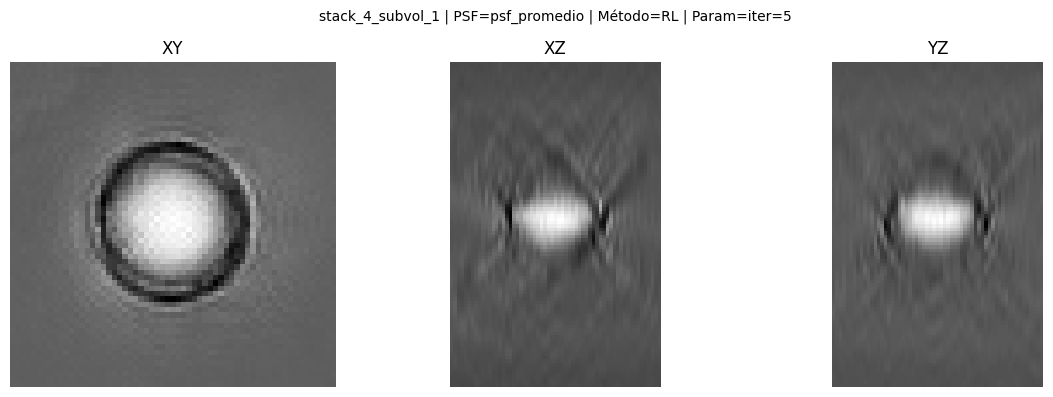

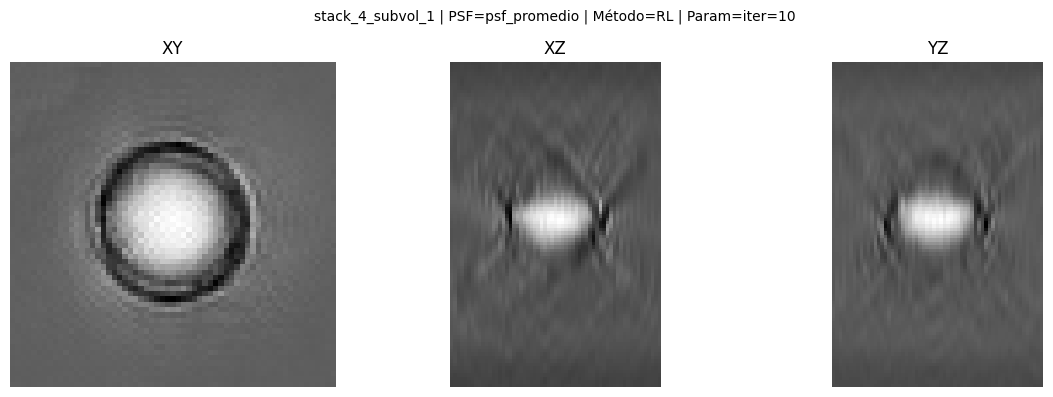

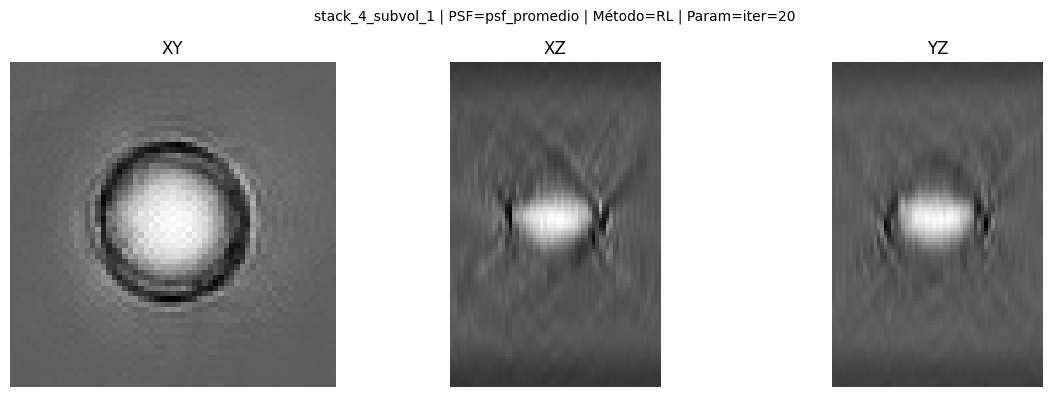

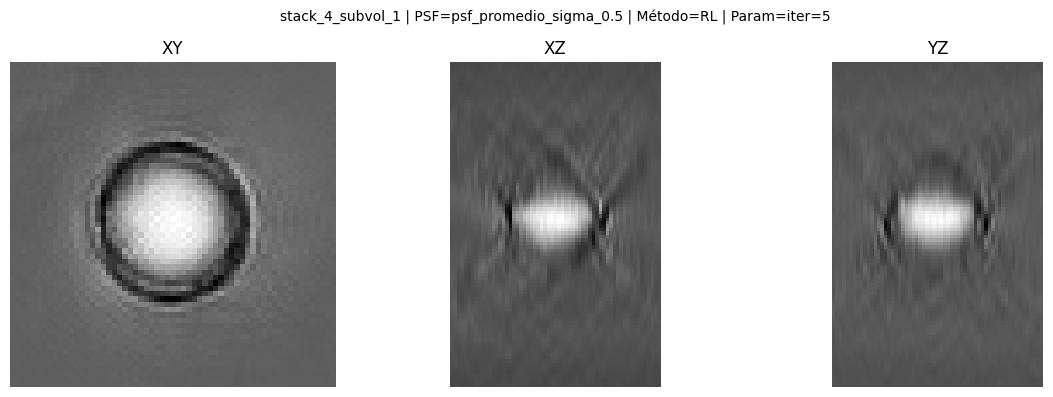

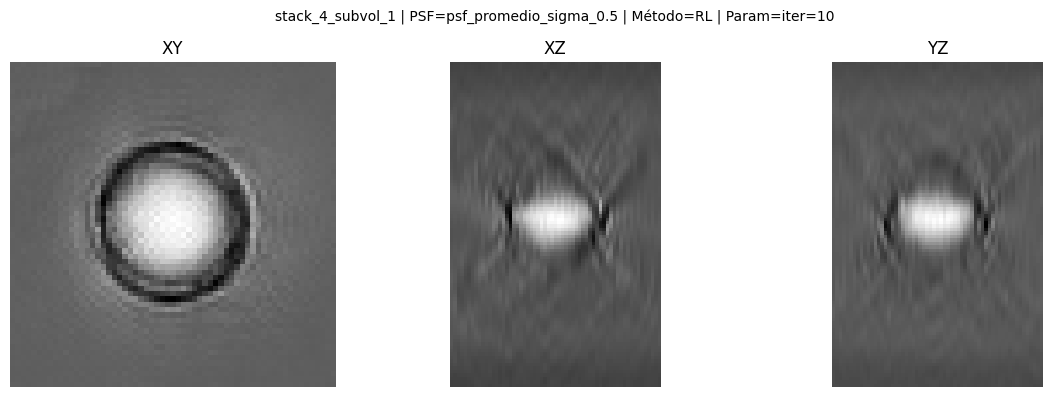

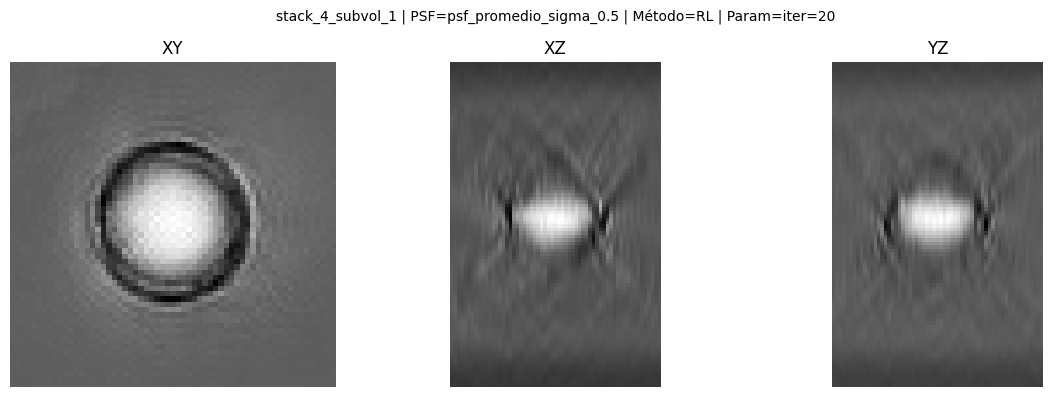

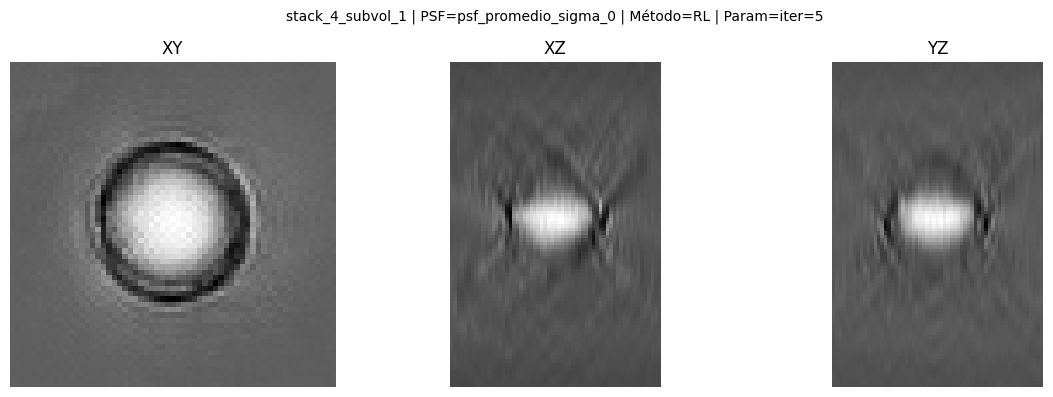

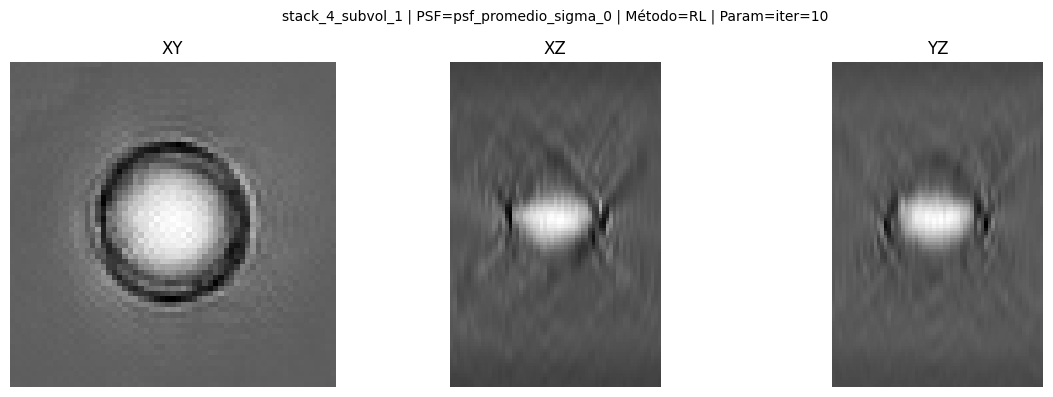

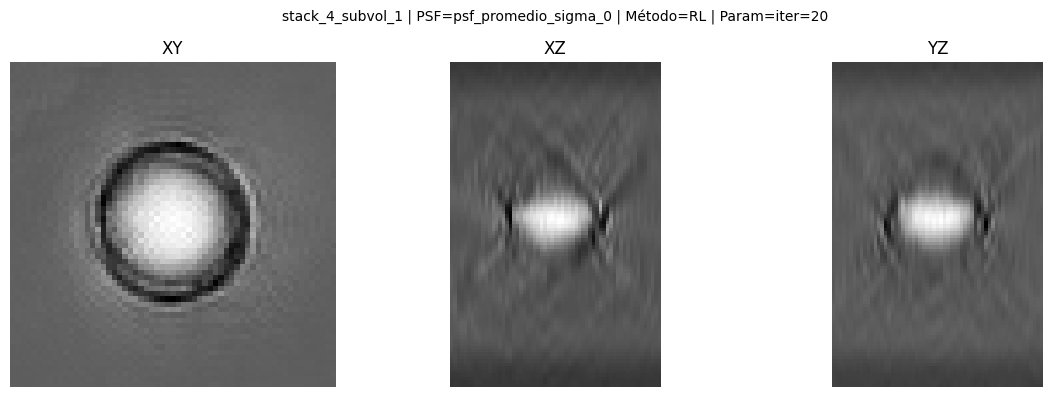

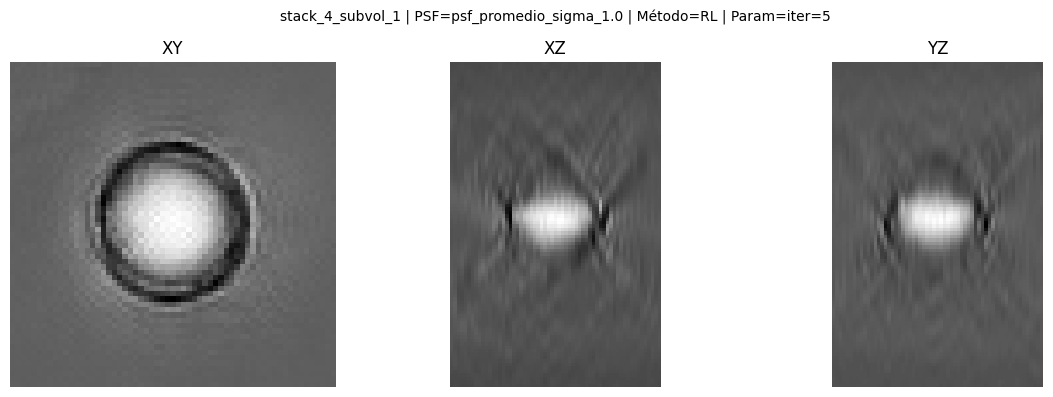

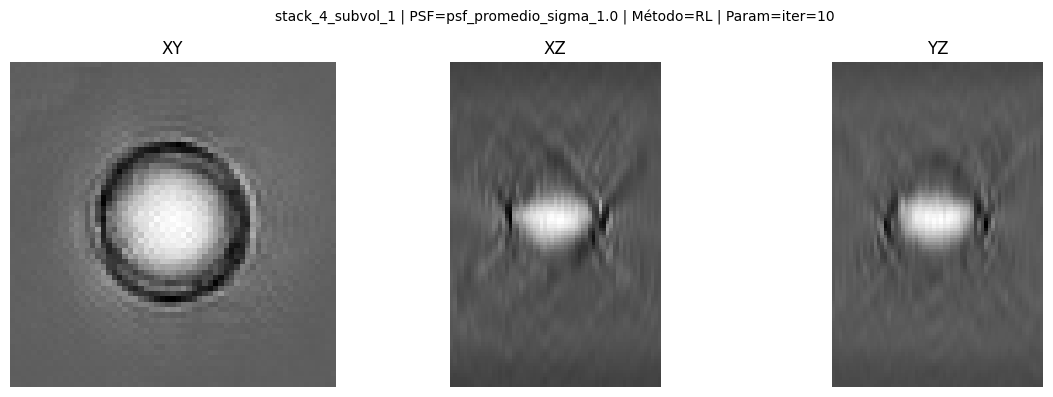

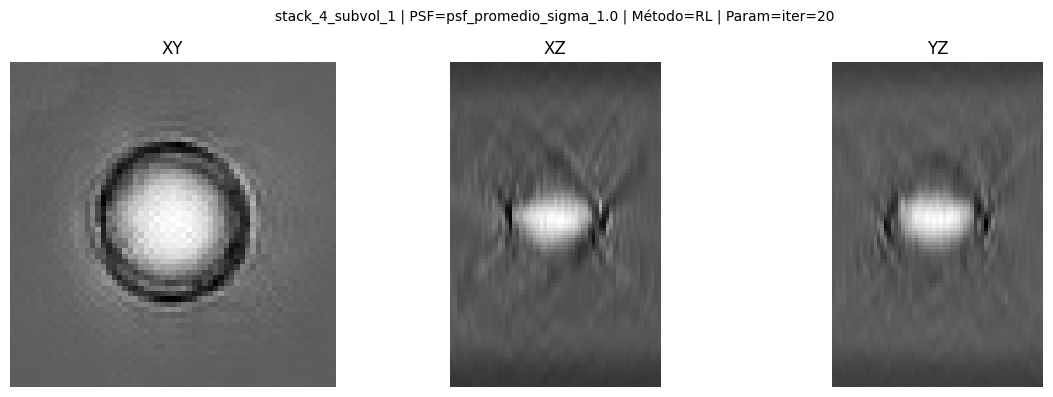

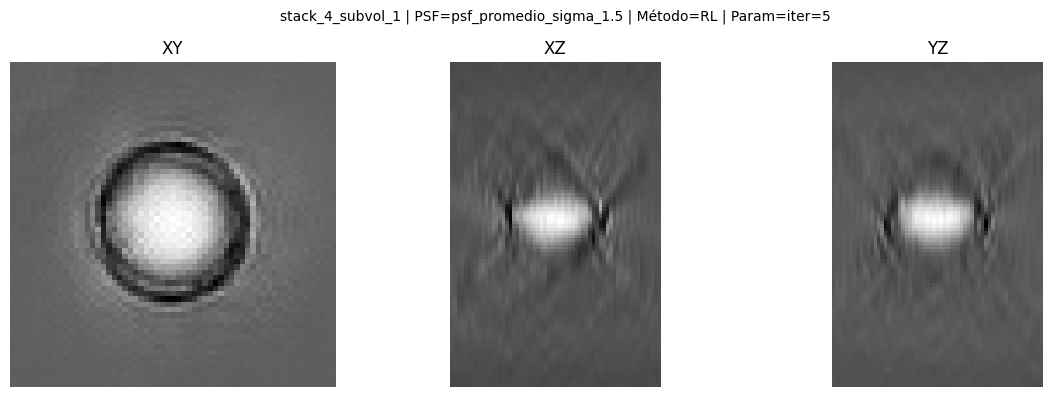

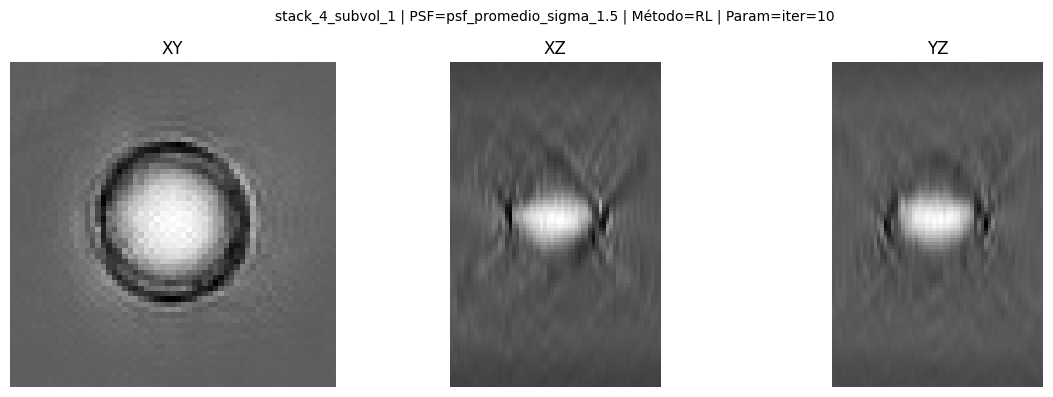

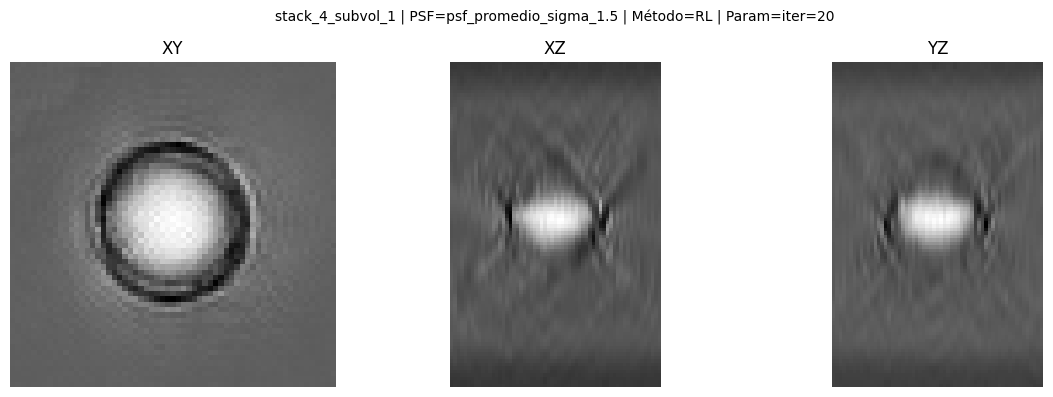

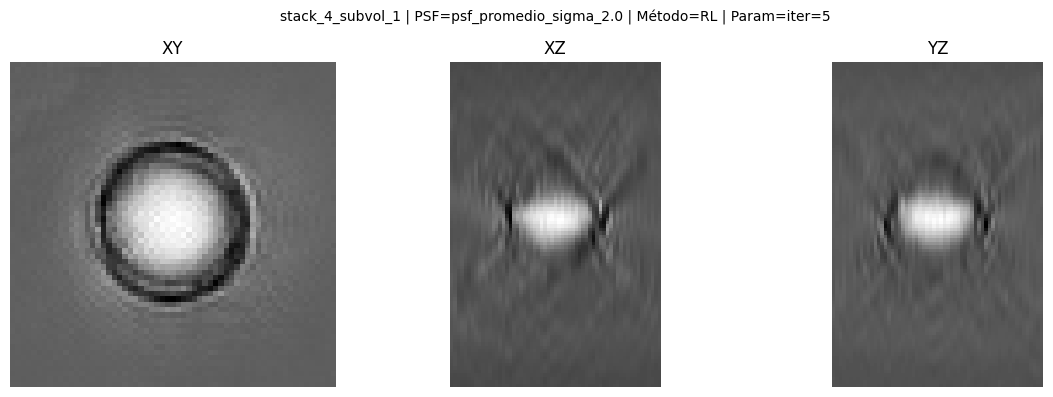

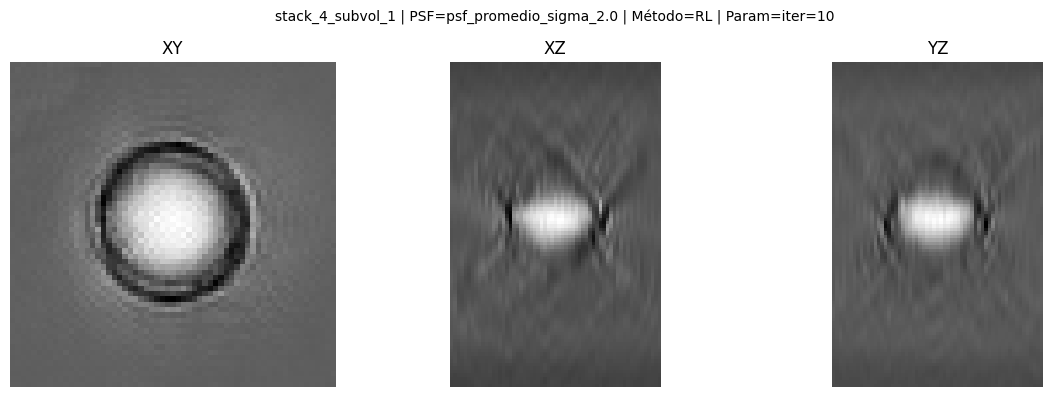

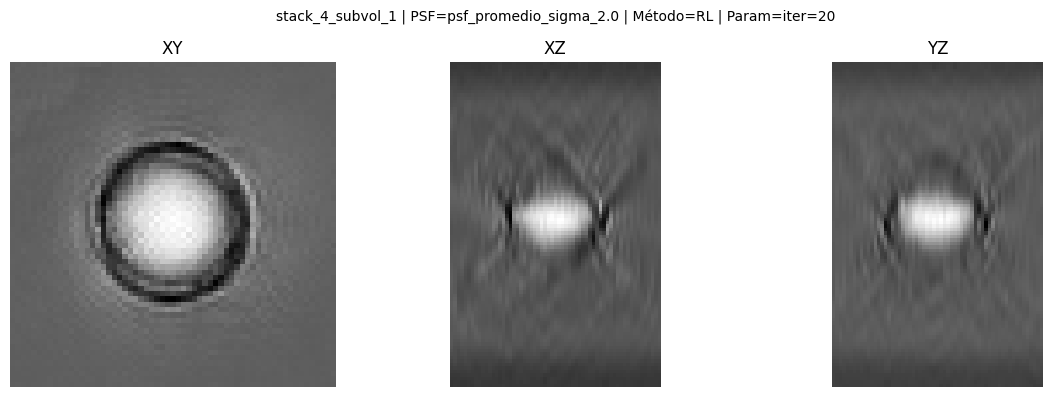

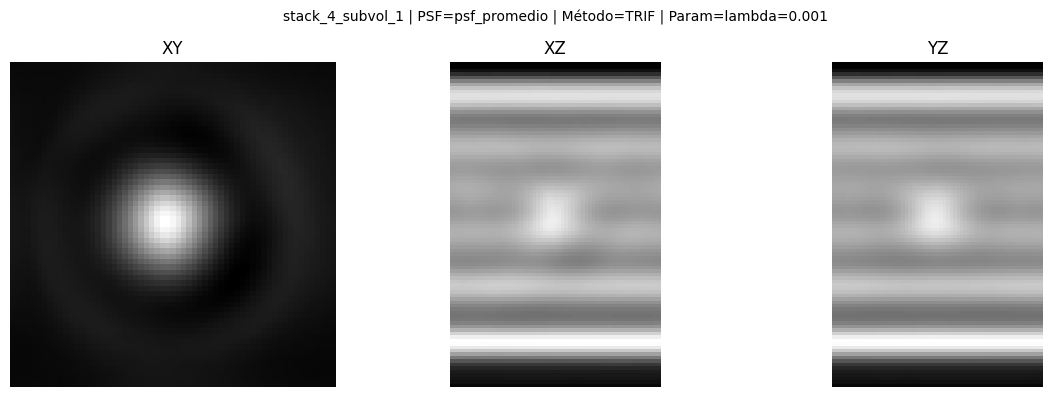

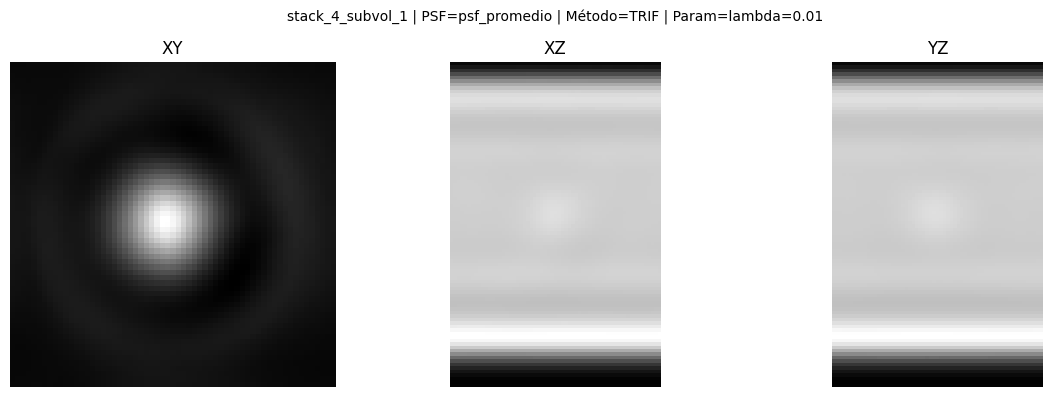

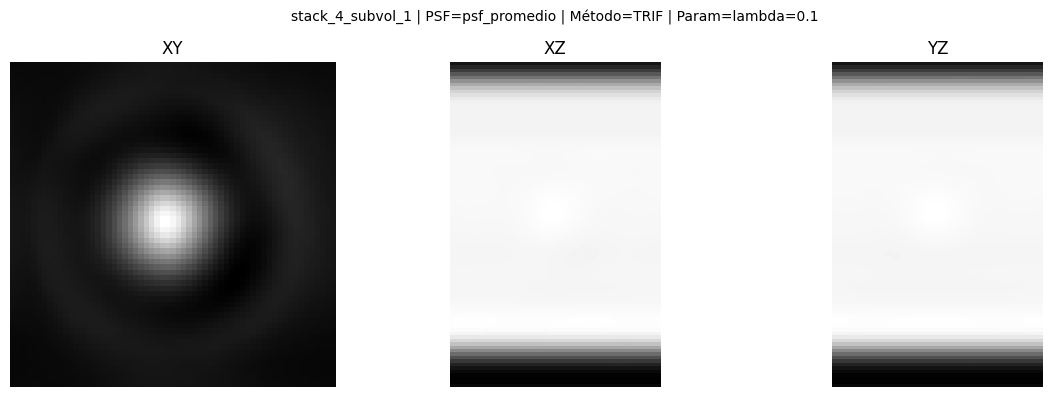

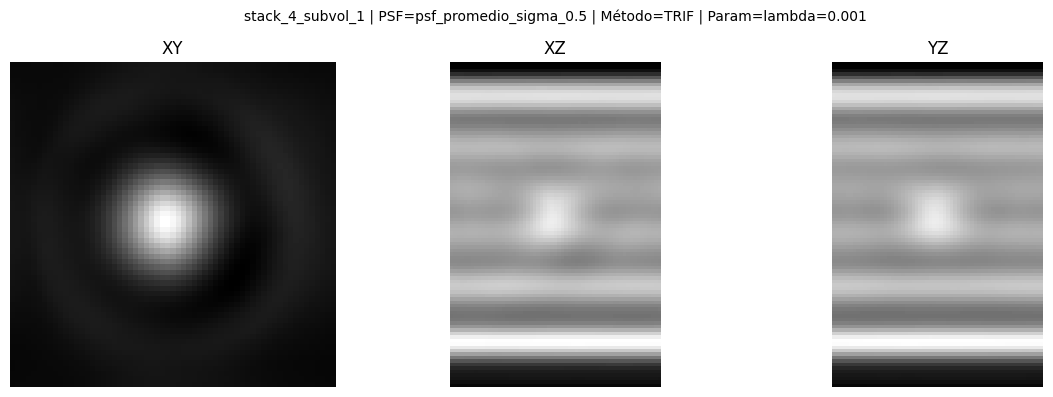

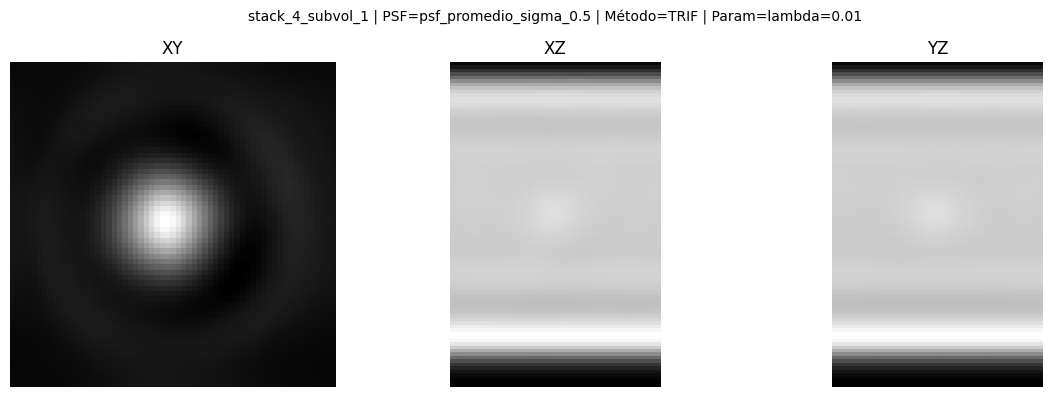

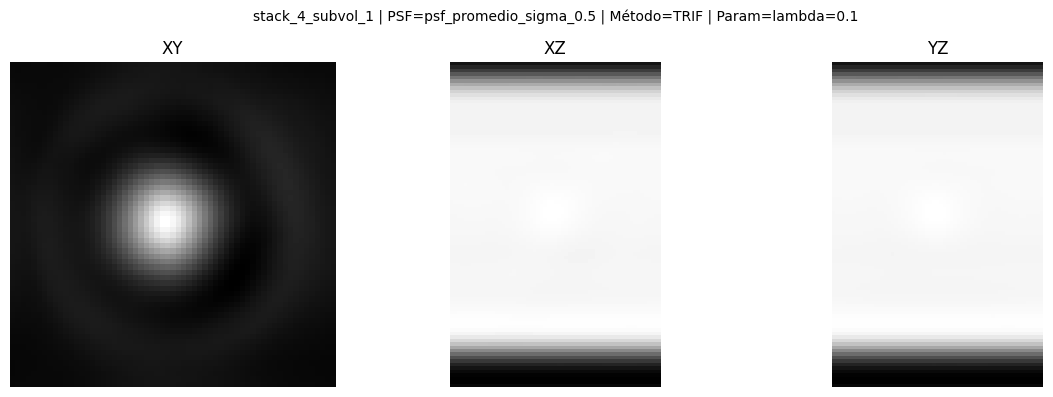

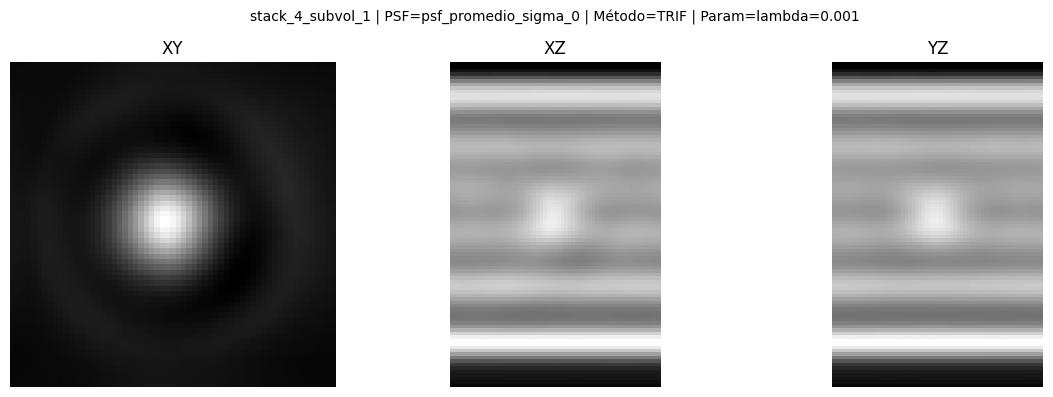

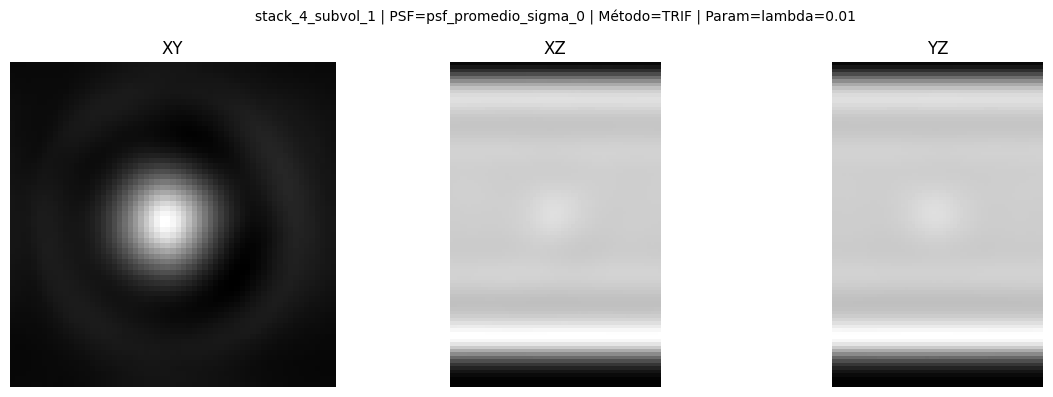

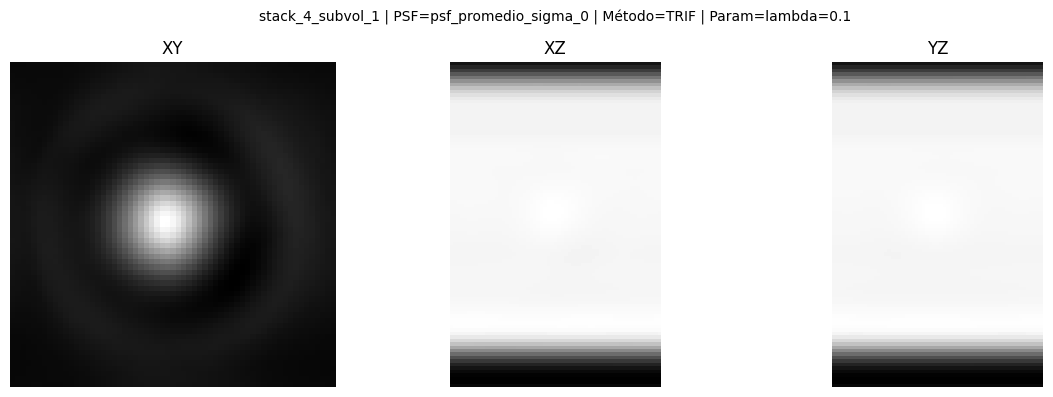

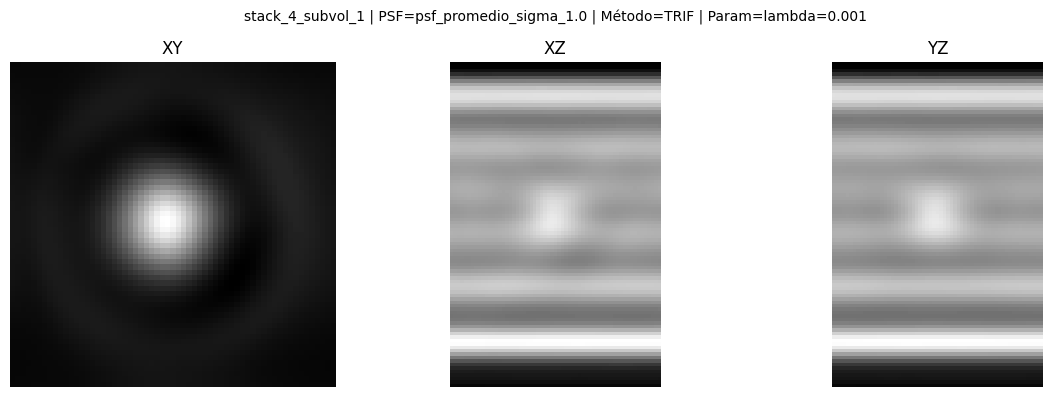

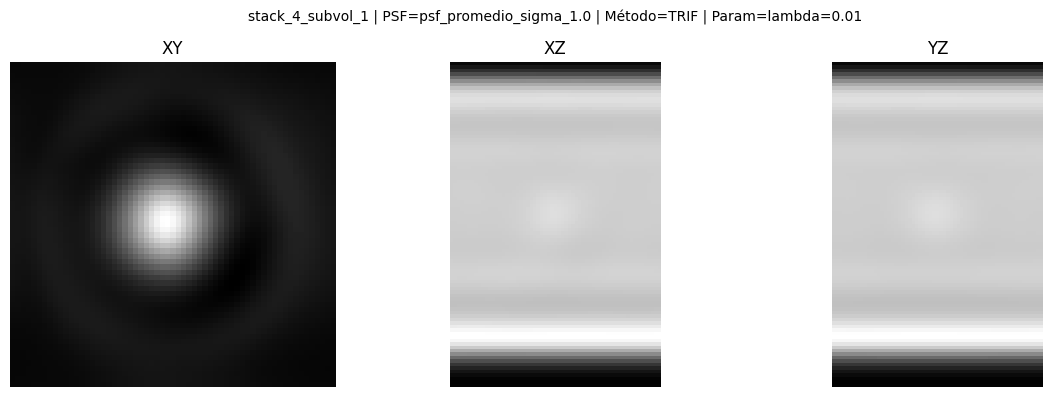

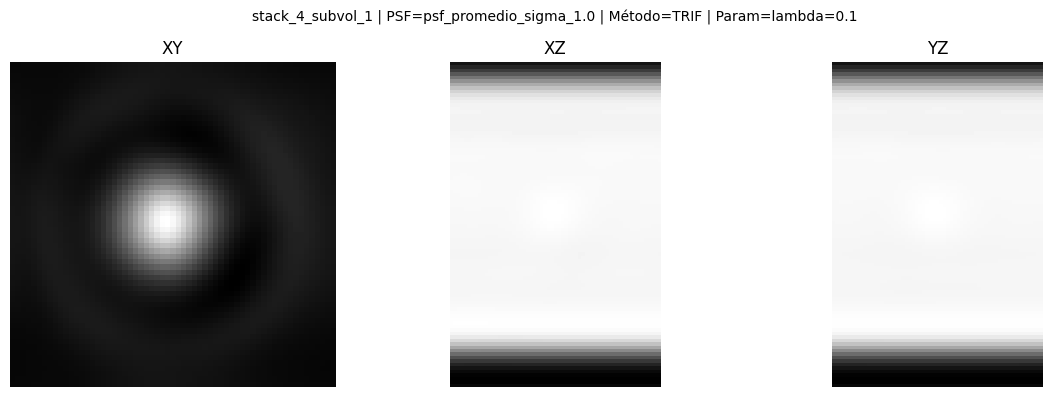

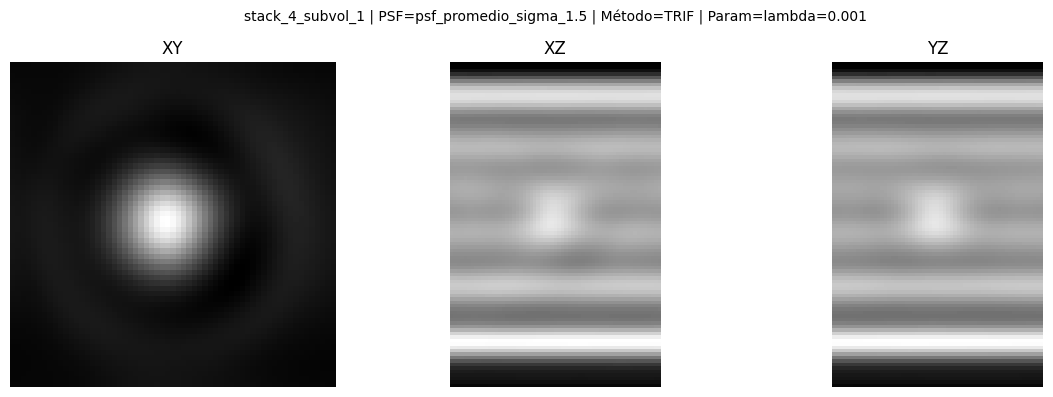

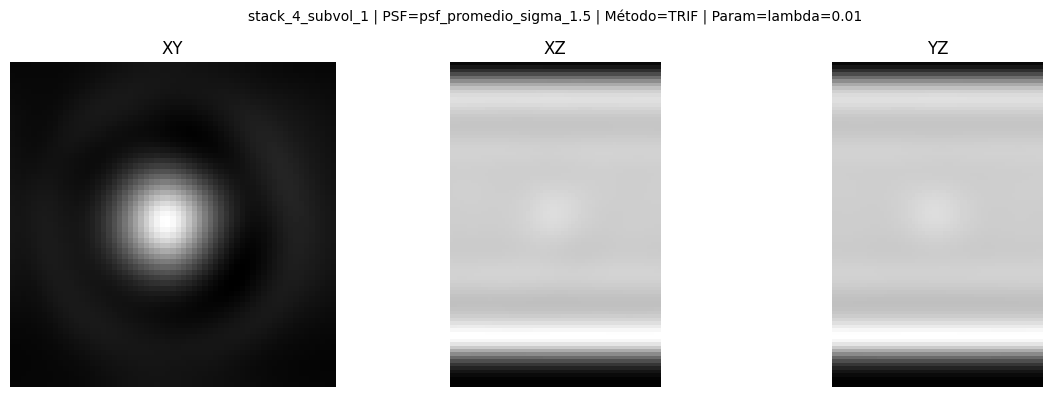

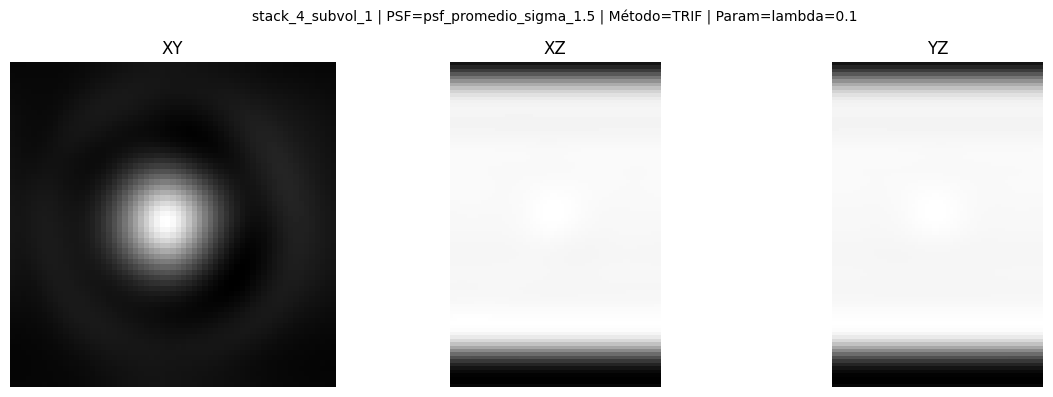

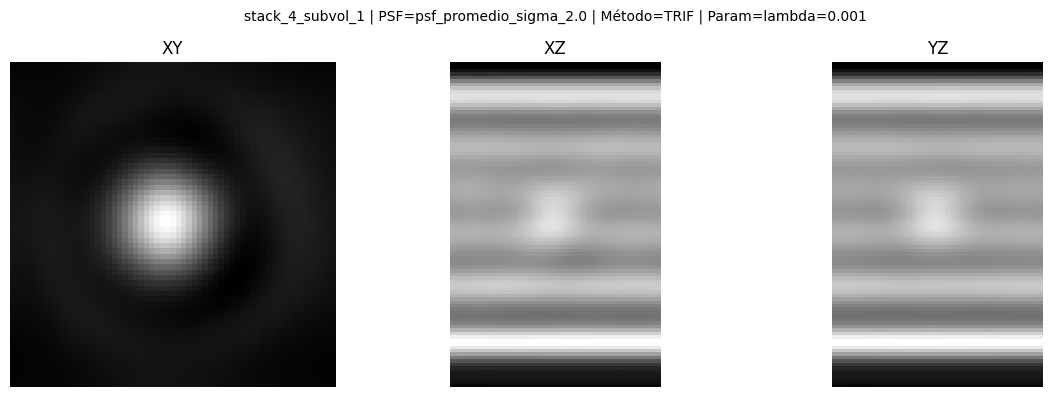

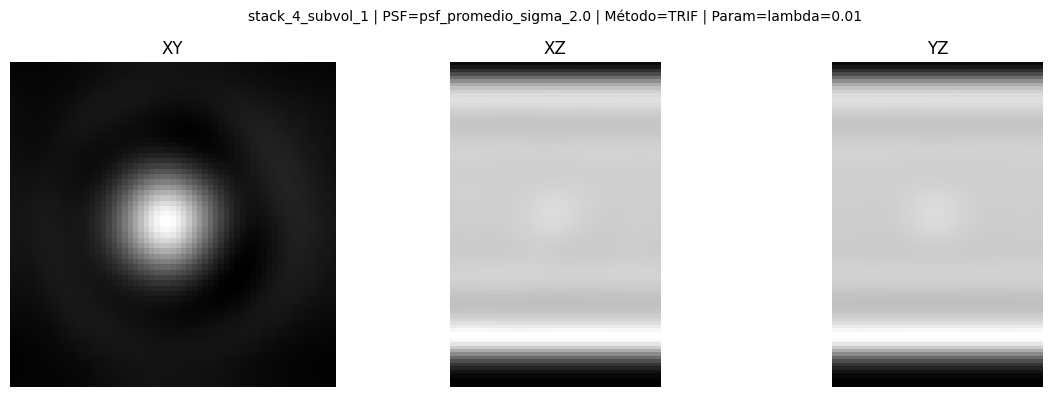

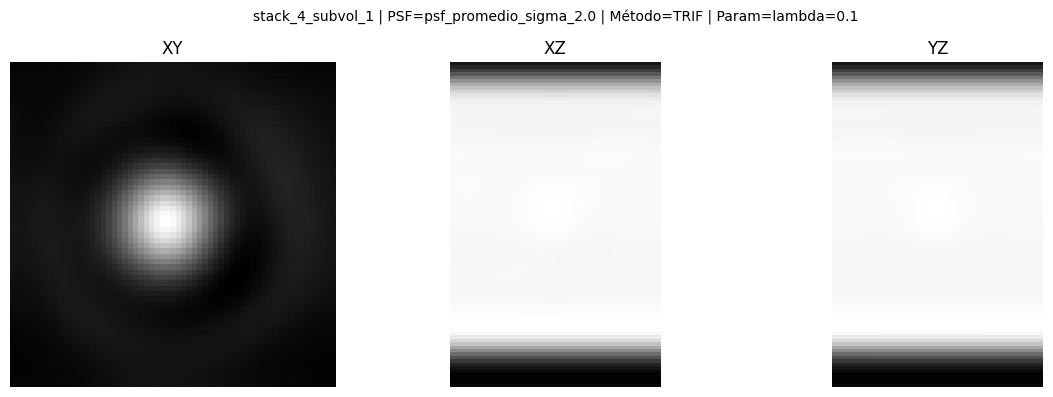

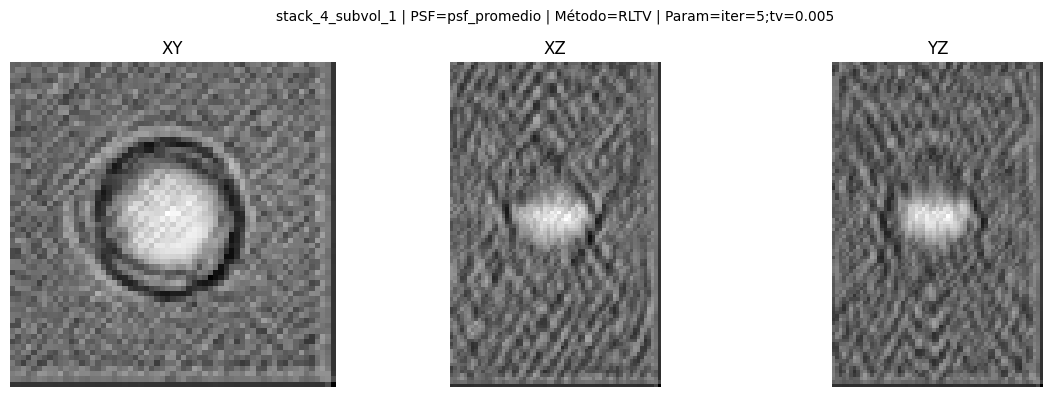

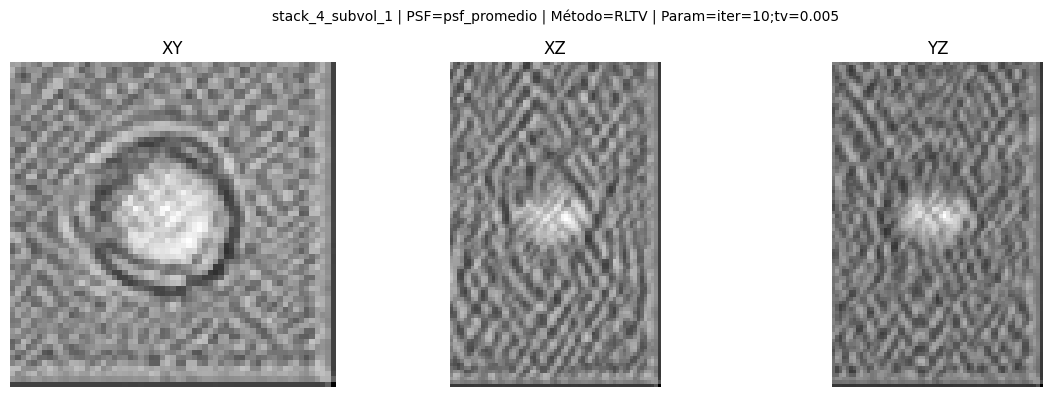

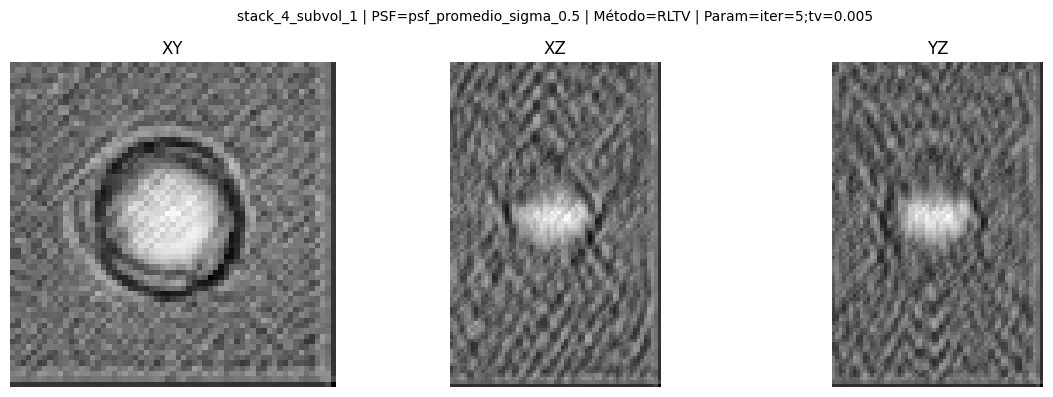

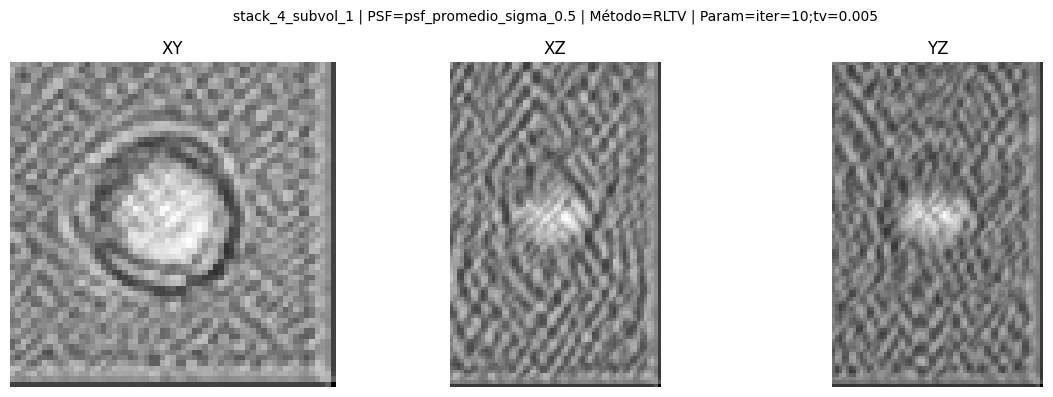

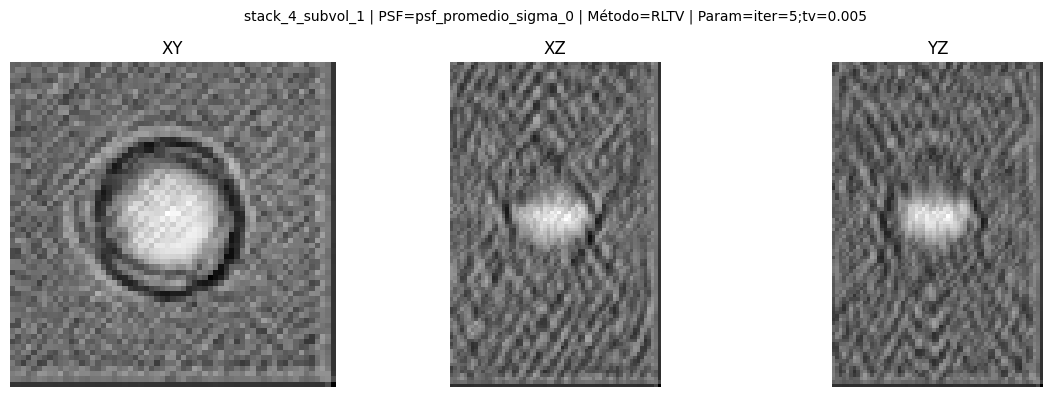

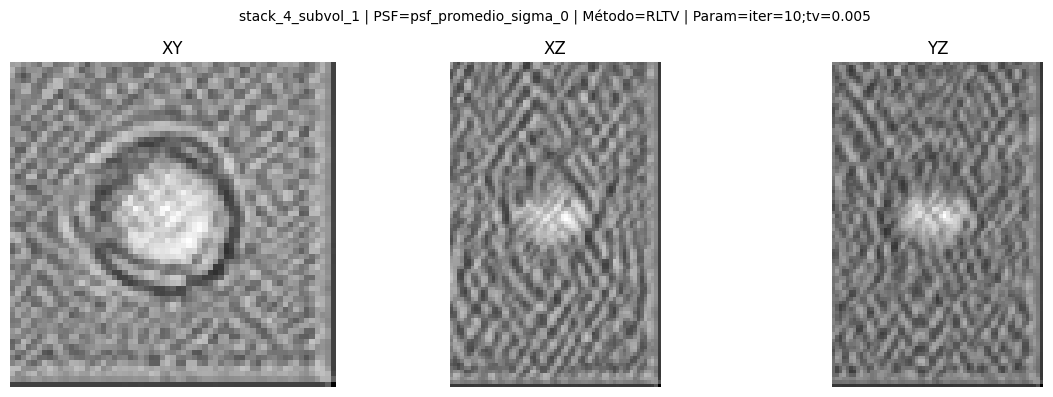

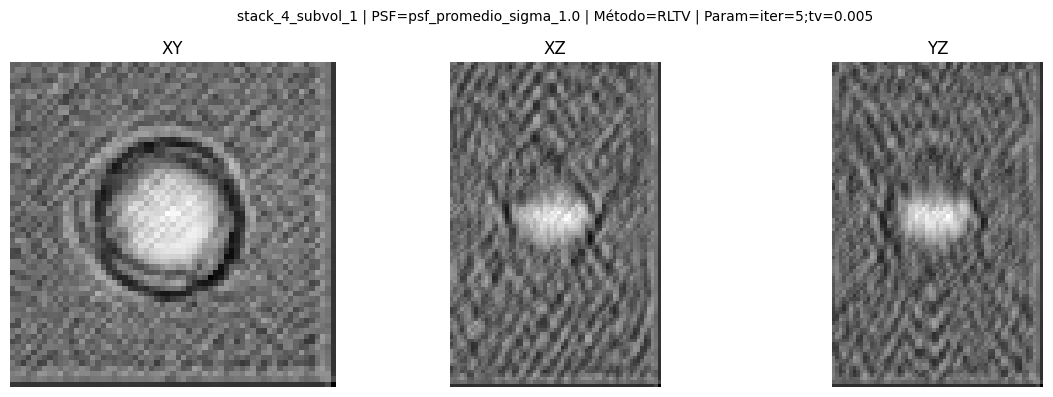

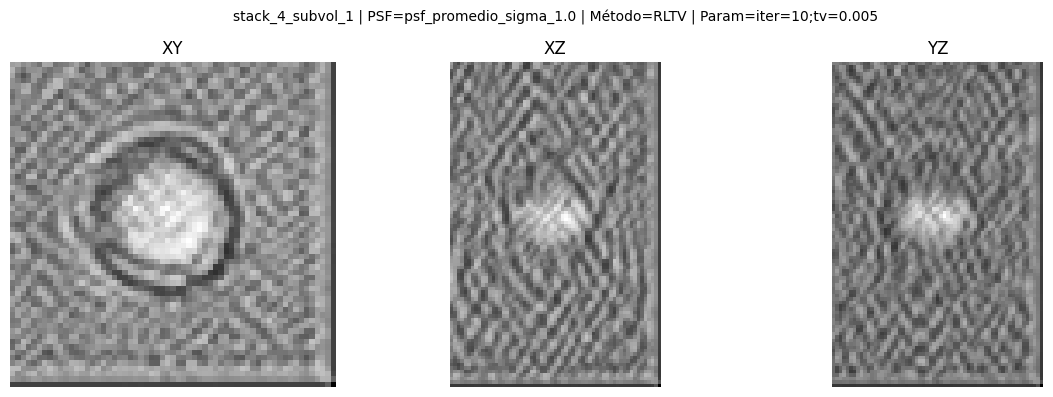

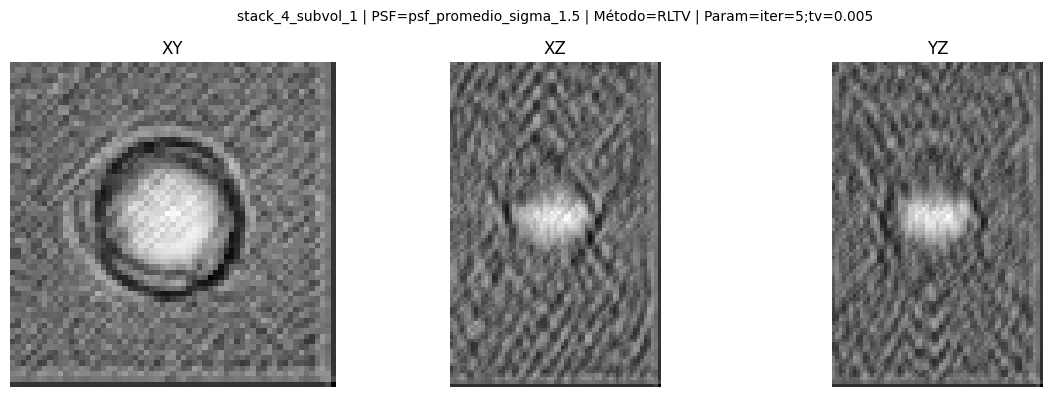

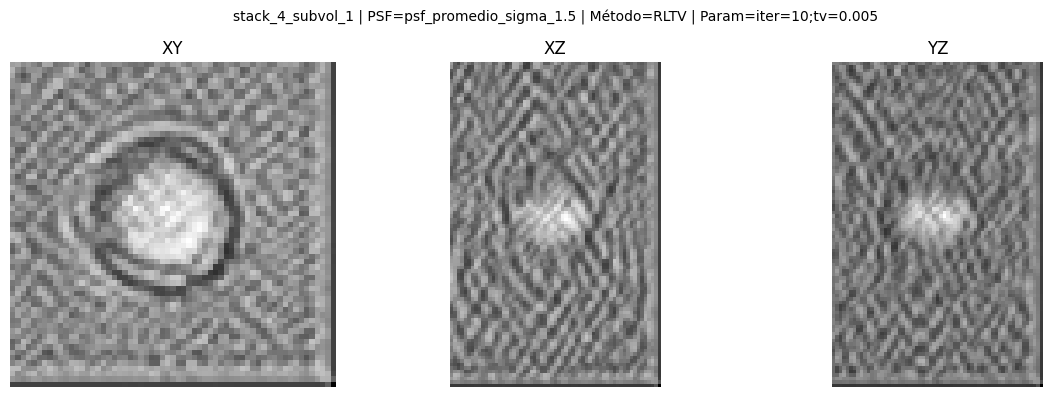

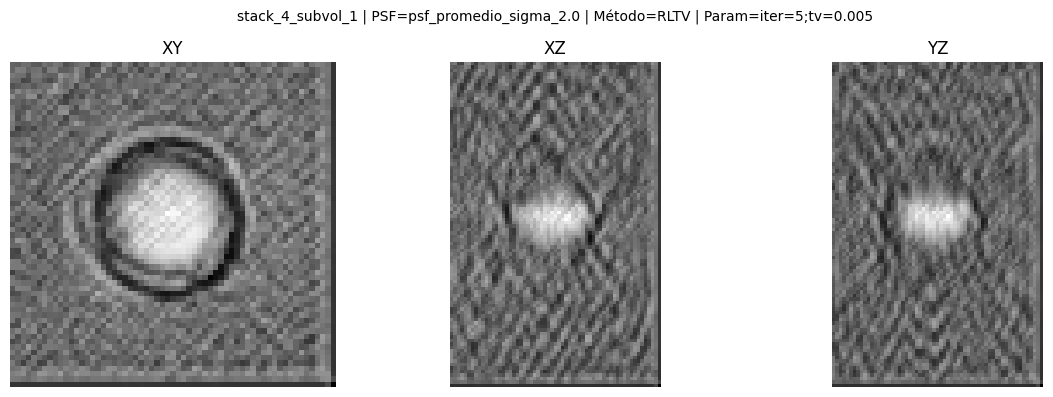

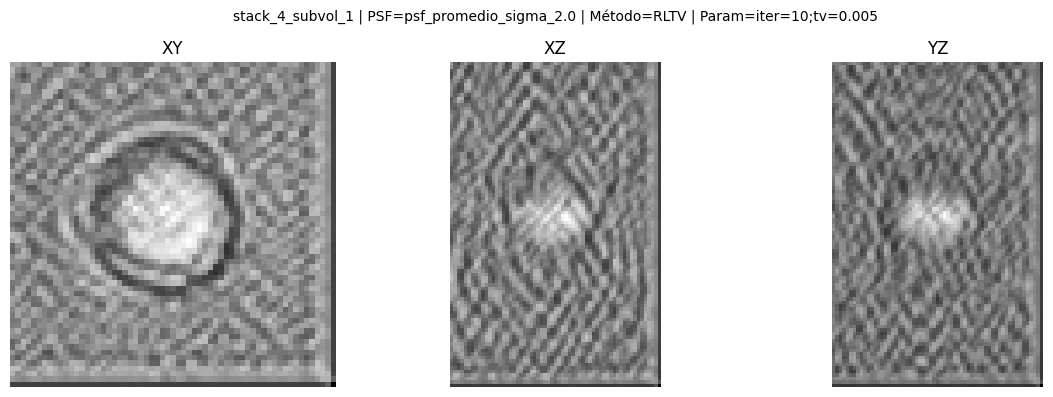

In [9]:
#Leer el CSV de log desde la ruta configurada
df = pd.read_csv(LOG_CSV_PATH)

#Elegir el subvolumen a mostrar (puedes parametrizar esto)
subvol_elegido = "stack_4_subvol_1"
df_subvol = df[df["Subvolumen"] == subvol_elegido]

#Para cada fila, cargar el TIFF desde la carpeta método/archivo y mostrar cortes
for _, row in df_subvol.iterrows():
    metodo    = row["Metodo"]
    archivo   = row["Archivo"]
    psf       = row["PSF"]
    parametro = row["Parametro"]

    # Ruta completa al .tif generado
    tiff_path = DECONV_RESULTS_DIR / metodo / archivo
    vol       = imread(str(tiff_path))

    # Cortes centrales
    z_c, y_c, x_c = np.array(vol.shape) // 2

    # Figura con los tres planos
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(vol[z_c],       cmap='gray'); axes[0].set_title("XY")
    axes[1].imshow(vol[:, y_c, :], cmap='gray'); axes[1].set_title("XZ")
    axes[2].imshow(vol[:, :, x_c], cmap='gray'); axes[2].set_title("YZ")
    for ax in axes:
        ax.axis('off')

    # Título informativo
    fig.suptitle(f"{subvol_elegido} | PSF={psf} | Método={metodo} | Param={parametro}", fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


El siguiente bloque de código construye, para tres subvolúmenes representativos, un diagrama de Pareto que visualiza de un vistazo qué configuraciones de deconvolución ofrecen el mejor equilibrio entre resolución (volumen central mínimo) y nitidez (SNR máximo). En términos generales:

Carga de datos: Lee el CSV que lista, para cada subvolumen, todos los archivos generados por los distintos métodos y parámetros de deconvolución.

Cálculo de métricas: 

Para cada combinación (método + parámetro) y para cada subvolumen:

- Carga el volumen TIFF resultante.

- Lo normaliza al rango [0,1].

- Cuenta qué porcentaje de voxels supera el 50 % (volumen efectivo).

- Mide la relación señal-ruido usando las capas exteriores como fondo.

Identificación del frente de Pareto

- Determina cuáles de esas combinaciones no son “domina­das” por ninguna otra (es decir, no hay otra que tenga simultáneamente menor volumen y mayor SNR).

- Visualización comparativa

- Genera tres subplots, uno por cada subvolumen, con:

- Puntos grises para todas las combinaciones.

- Puntos naranjas para las soluciones Pareto.

- Etiquetas sobre esos puntos óptimos indicando método y parámetro.

In [ ]:


# Subvolúmenes de interés
targets = ["stack_4_subvol_1", "stack_1_subvol_1", "stack_2_subvol_1"]

# Leer el CSV de resultados de deconvolución
df = pd.read_csv(LOG_CSV_PATH)

# Preparar figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, subvol in zip(axes, targets):
    df_sub = df[df["Subvolumen"] == subvol]
    metrics = []

    # 1) Calcular métricas
    for _, row in df_sub.iterrows():
        metodo  = row["Metodo"]
        archivo = row["Archivo"]
        vol_arr = imread(str(DECONV_RESULTS_DIR / metodo / archivo))

        # Normalizar al rango [0,1]
        vmin, vmax = vol_arr.min(), vol_arr.max()
        vol_n = (vol_arr - vmin) / (vmax - vmin)

        # Volumen ≥50%
        vol_pct = np.sum(vol_n >= 0.5) / vol_n.size * 100

        # SNR (pico / σ fondo)
        signal = vol_n.max()
        bkg = np.concatenate([
            vol_n[:3].ravel(), vol_n[-3:].ravel(),
            vol_n[:, :3, :].ravel(), vol_n[:, -3:, :].ravel(),
            vol_n[:, :, :3].ravel(), vol_n[:, :, -3:].ravel()
        ])
        snr = signal / bkg.std() if bkg.std() > 0 else np.nan

        metrics.append({
            "Método": metodo,
            "Parámetro": row["Parametro"],
            "vol_pct": vol_pct,
            "snr": snr
        })

    df_m = pd.DataFrame(metrics)

    # Calcular frente de Pareto
    vols = df_m['vol_pct'].values
    snrs = df_m['snr'].values
    pareto_mask = []
    for i, (v_i, s_i) in enumerate(zip(vols, snrs)):
        dominated = any(
            (v_j <= v_i and s_j >= s_i) and (v_j < v_i or s_j > s_i)
            for j, (v_j, s_j) in enumerate(zip(vols, snrs)) if j != i
        )
        pareto_mask.append(not dominated)
    df_p = df_m[pareto_mask]

    #Scatter y etiquetado
    ax.scatter(vols, snrs, alpha=0.4, label='Todas')
    ax.scatter(df_p['vol_pct'], df_p['snr'], color='orange',
               edgecolor='k', s=100, label='Pareto')
    for _, prow in df_p.iterrows():
        ax.text(prow['vol_pct'], prow['snr'],
                f"{prow['Método']}\n{prow['Parámetro']}",
                ha='left', va='bottom', fontsize=12)

    ax.set_title(subvol)
    ax.set_xlabel("Volumen ≥50 % (%)")
    ax.set_ylabel("SNR")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
